<a href="https://colab.research.google.com/github/vasudhab21/ML-LAB/blob/main/ML_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
from google.colab import drive
import os
import gzip
import shutil

# Mount Google Drive
drive.mount('/content/gdrive')

# Folder path
data_folder = '/content/gdrive/MyDrive/GenomeDetector/data/natural2'

# List all .fna.gz files in the folder
gz_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.fna.gz')]
print(f"Found {len(gz_files)} compressed files.")

# Decompress each .fna.gz to .fasta (keep original .gz files)
for gz_file in gz_files:
    fasta_file = gz_file[:-3]  # Remove .gz extension
    with gzip.open(gz_file, 'rb') as f_in:
        with open(fasta_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Decompressed {gz_file} to {fasta_file}")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 205 compressed files.
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000839185.1_ViralProj14174_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000839185.1_ViralProj14174_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000857045.1_ViralProj15142_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000857045.1_ViralProj15142_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_014621545.1_ASM1462154v1_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_014621545.1_ASM1462154v1_genomic.fna
Decompressed /content/gdrive/MyDrive/GenomeDetector/data/natural2/viral_GCF_000860085.1_ViralProj15241_genomic.fna.gz to /content/gdrive/MyDrive/GenomeDetector/data/natural2/vi

In [3]:
%pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 48.1 MB/s eta 0:00:00


In [4]:
from Bio import SeqIO
from collections import Counter
import os
import numpy as np
import pandas as pd

def get_kmers(sequence, k=4):
    return [str(sequence[i:i+k]) for i in range(len(sequence) - k + 1)]

def count_kmers(sequence, k=4):
    kmers = get_kmers(sequence, k)
    counts = Counter(kmers)
    total = sum(counts.values())
    freqs = {kmer: count / total for kmer, count in counts.items()}
    return freqs

def build_kmer_feature_vector(freqs, possible_kmers):
    vector = np.zeros(len(possible_kmers))
    for i, kmer in enumerate(possible_kmers):
        vector[i] = freqs.get(kmer, 0)
    return vector

def get_all_possible_kmers(k=4):
    from itertools import product
    bases = ['A', 'C', 'G', 'T']
    return [''.join(p) for p in product(bases, repeat=k)]

def find_fasta_files(base_path):
    fasta_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.fasta') or file.endswith('.fna'):
                fasta_files.append(os.path.join(root, file))
    return fasta_files

# Adjust these paths based on your dataset organization
natural_folder = '/content/gdrive/MyDrive/GenomeDetector/data/natural2'
synthetic_folder = '/content/gdrive/MyDrive/GenomeDetector/data/engineered'

natural_files = find_fasta_files(natural_folder)
synthetic_files = find_fasta_files(synthetic_folder)

possible_kmers = get_all_possible_kmers(k=4)

def process_files(fasta_files, label):
    features = []
    labels = []
    for fasta_file in fasta_files:
        for record in SeqIO.parse(fasta_file, "fasta"):
            seq = record.seq.upper()
            freqs = count_kmers(seq, k=4)
            vec = build_kmer_feature_vector(freqs, possible_kmers)
            features.append(vec)
            labels.append(label)
    return features, labels

natural_features, natural_labels = process_files(natural_files, label=0)
synthetic_features, synthetic_labels = process_files(synthetic_files, label=1)

X = np.array(natural_features + synthetic_features)
y = np.array(natural_labels + synthetic_labels)

df = pd.DataFrame(X, columns=possible_kmers)
df['label'] = y

df.to_csv('/content/gdrive/MyDrive/GenomeDetector/kmer_features_labels.csv', index=False)
print("Feature extraction complete. Data saved to kmer_features_labels.csv")


Feature extraction complete. Data saved to kmer_features_labels.csv


In [5]:
print(f'Number of natural sequences: {len(natural_labels)}')
print(f'Number of synthetic sequences: {len(synthetic_labels)}')


Number of natural sequences: 9483
Number of synthetic sequences: 5000


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

def train_linear_regression(X_train, y_train):
    # Training the linear regression model
    reg = LinearRegression().fit(X_train, y_train)
    return reg

def evaluation_metrics(y_train, y_train_pred):
    # Computing the evaluation metrics
    mse =  mean_squared_error(y_train, y_train_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    return mse, rmse, mape

def k_means(X, n_clusters):
    # Performing k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(X)
    return kmeans

def evaluate_clustering(X, labels):
    # Evaluating clusters based on silhoutte score, ch index and, db index
    silhouette = silhouette_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    return silhouette, calinski_harabasz, davies_bouldin

def elbow_plot(X, max_k=15):
    # Plotting the elbow plot
    distortions = []
    for k in range(2, max_k + 1):
        model = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
        distortions.append(model.inertia_)
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.title("A7: Elbow Plot for Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

# Loading the CSV
df = pd.read_csv('/content/gdrive/MyDrive/GenomeDetector/kmer_features_labels.csv')

# Extracting the features
X = df.drop(columns=['label']).values

# Extracting the labels
y = df['label'].values

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*Assignment 1, 2*

In [18]:
# A1 & A2: Regression with One Feature
X_train_one = X_train[:, [0]]
X_test_one = X_test[:, [0]]
reg_single = train_linear_regression(X_train_one, y_train)
y_train_pred_one = reg_single.predict(X_train_one)
y_test_pred_one = reg_single.predict(X_test_one)
mse_train, rmse_train, mape_train= evaluation_metrics(y_train, y_train_pred_one)
mse_test, rmse_test, mape_test = evaluation_metrics(y_test, y_test_pred_one)

print(f"Train -> MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.4f}")
print(f"Test  -> MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.4f}")

Train -> MSE: 0.2255, RMSE: 0.4749, MAPE: 101564113880761408.0000
Test  -> MSE: 0.2239, RMSE: 0.4732, MAPE: 102375780040172960.0000


*Assignment 3*

In [10]:
# A3: Regression with All Features
reg_all = train_linear_regression(X_train, y_train)
y_train_pred_all = reg_all.predict(X_train)
y_test_pred_all = reg_all.predict(X_test)
mse_tr_all, rmse_tr_all, mape_tr_all= evaluation_metrics(y_train, y_train_pred_all)
mse_te_all, rmse_te_all, mape_te_all = evaluation_metrics(y_test, y_test_pred_all)

print(f"Train -> MSE: {mse_tr_all:.4f}, RMSE: {rmse_tr_all:.4f}, MAPE: {mape_tr_all:.4f}")
print(f"Test  -> MSE: {mse_te_all:.4f}, RMSE: {rmse_te_all:.4f}, MAPE: {mape_te_all:.4f}")

Train -> MSE: 0.0894, RMSE: 0.2991, MAPE: 51929581244379616.0000
Test  -> MSE: 0.1034, RMSE: 0.3215, MAPE: 52016871804383584.0000


*Assignment 4*

In [12]:
# A4: K-Means clustering
kmeans = k_means(X, n_clusters=2)
print(f"Cluster Centers:\n{kmeans.cluster_centers_}")

Cluster Centers:
[[0.00056886 0.00079437 0.00085826 0.00062795 0.00158631 0.00192166
  0.0027077  0.00127229 0.00197153 0.0032545  0.00350891 0.00136589
  0.00036818 0.0013804  0.0008948  0.00050229 0.00126135 0.00190978
  0.00214458 0.00159105 0.00339388 0.00339394 0.00580214 0.00360602
  0.00458984 0.00699166 0.00526068 0.00319722 0.00044922 0.00156497
  0.00170169 0.00124103 0.00211237 0.00214393 0.00208648 0.00197602
  0.00413353 0.0051877  0.00812214 0.00385227 0.00374567 0.00704648
  0.00414982 0.00352005 0.00063116 0.00188513 0.00121036 0.00128433
  0.00023071 0.0005573  0.00075857 0.00037709 0.00242682 0.00313056
  0.00540697 0.00200265 0.0022963  0.00322806 0.00325255 0.00155419
  0.00021345 0.00115794 0.00095736 0.00063624 0.00071528 0.00276307
  0.00320358 0.00098792 0.00154576 0.00740807 0.00671137 0.00122529
  0.00247087 0.00885626 0.00733298 0.00171696 0.00059044 0.00529829
  0.00367763 0.00092659 0.00209275 0.0058542  0.00779926 0.00327018
  0.00460119 0.00528718 0.00883

*Assignment 5*

In [14]:
# A5: Evaluating clusters based on Silhoutte score, CH score, DB index
silhouette, ch_score, db_index = evaluate_clustering(X, kmeans.labels_)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

Silhouette Score: 0.1764
Calinski-Harabasz Score: 944.7374
Davies-Bouldin Index: 2.5432


*Assignment 6*

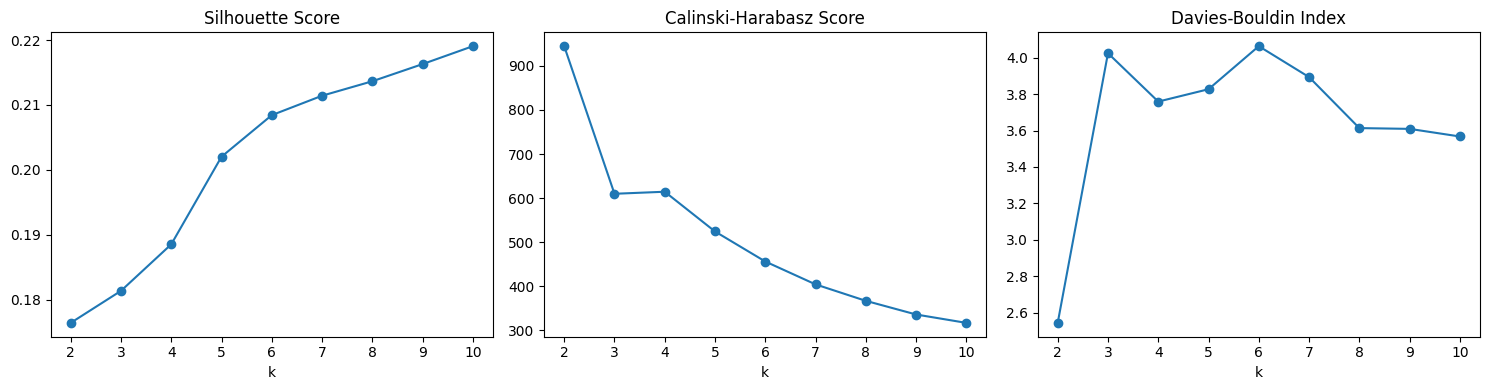

In [15]:
# A6: Clustering Scores for Multiple k
k_values = list(range(2, 11))
silhouettes = []
chs = []
dbs = []

for k in k_values:
    model = k_means(X, n_clusters=k)
    s, c, d = evaluate_clustering(X, model.labels_)
    silhouettes.append(s)
    chs.append(c)
    dbs.append(d)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(k_values, silhouettes, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")

plt.subplot(1, 3, 2)
plt.plot(k_values, chs, marker='o')
plt.title("Calinski-Harabasz Score")
plt.xlabel("k")

plt.subplot(1, 3, 3)
plt.plot(k_values, dbs, marker='o')
plt.title("Davies-Bouldin Index")
plt.xlabel("k")

plt.tight_layout()
plt.show()

*Assignment 7*

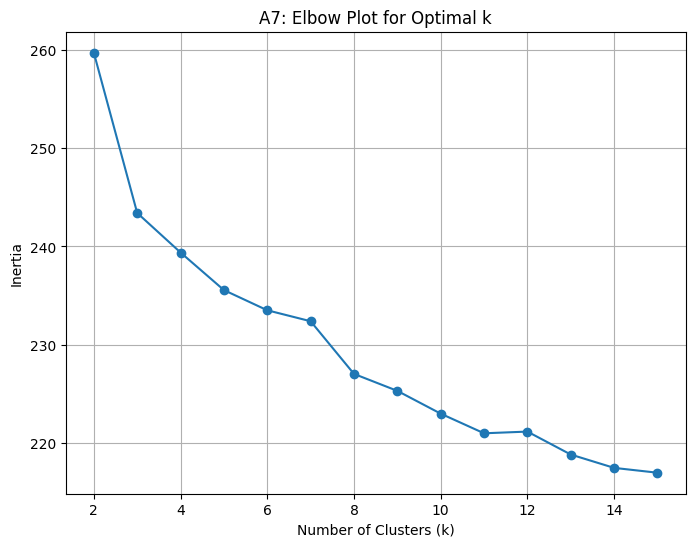

In [16]:
# A7: Elbow Plot for Optimal k
elbow_plot(X, max_k=15)